# AMS Project 553
### Benjamin Nicholson & Nick Christophedes

As part of AMS 553 at Stony Brook University the students have been tasked with a final project that looks to utilize skills learned from the class to create an advanced queueing simulation. As both Ben and Nick are Quantitative Finance students they saw an opportunity to utilize queueing theory to emulate the Log Order Book (LOB)

#### Overview
Traditional financial markets evolved from groups of people wanting to buy a product and a group of people wanting to sell a product. These groups used to meet in a physical location where they could offer a price and a volume of stock for a price. With multiple agents interacting a market price begins to form. Modern markets have adapted to utilize the speed of computers to create electronic markets. The creation of a limit order book has allowed for customers to join queues where they keep their trade at a price with the hopes that it is met with the opposing supply/demand at that particular price point. 

#### Market Maker vs Non Market Maker
Electronic markets have allowed for much faster trade processing times which has created a smoother experience for all traders. However one issue that remains when the only agents are buyers and sellers. There is commonly not enough liquidity for a trade to take place, if there are large price movements you might want to cash out your profits just to find that there is no one who is willing to take your price. Another issue is that if buyers and sellers cannot agree on a price then trades will not occur and a bid/ask spread is created. The bid ask spread has the lowest ask and the highest bid that either group of agents are willing to spend for a product. These two problems have found a solution in a new agent to electronic markets, the market maker. They provide liquidity at prices more desirable for investors.

### Project Intention
We hope to showcase the importance of market makers by looking at a variety of output metrics while indicating that market makers can have a vested interest in providing their services through their own profits.

#### Agents


#### Project Setup
n_investor_types is the number of different types of investors. All of these different types of investors have their own noise and exponential distribution. A further extension of this is to create different types of investors with a different n_investor_types for each type.

Buyers: They want to 
Sellers:

## Methodology

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heapq
import simpy

In [2]:
class Distribution:
    """
    Distributions class will be used for random variate generation
    """
    def __init__(self, sampler):
        self.sampler = sampler

    def sample(self):
        return self.sampler()

In [3]:
class Order:
    def __init__(self,order_id, investor_id, price, time, side):
        """
        Attrbiutes:
        investor_id: Unique identifier for the investor placing the order
        price: The price at which the order is placed
        time: The timestamp when the order is placed
        side: 'buy' or 'sell' indicating the type of order

        """
        self.id = order_id
        self.investor_id = investor_id
        self.price = price
        self.time = time
        self.side = side

        self.exeuction_time =  None
        self.is_filled = False


In [4]:
class OrderBook:
    """
    Attributes:
    - p0: initial price of the asset
    - bids: list of buy orders (max heap)
    - asks: list of sell orders (min heap)
    
    Methods:
    - best_bid(): returns the highest bid price
    - best_ask(): returns the lowest ask price
    - midpoint_price(): returns the midpoint price between best bid and best ask
    - add_order(order): adds an order to the order book
    """
    def __init__(self,p0): 
        self.p0 = p0 # initial fundamental price of a product
        self.bids = []  # max heap - priority queue 
        self.asks = []  # min heap - priority queue of asks
        self.best_bid_list = []
        self.best_ask_list = []
        self.all_bids = []
        self.all_asks = []
        self.trade_history = [] 
        self.next_order_id_counter = 0
        self.orderbook_history = [] 
        self.all_orders = []
        self.pct_filled_ts = []

        
    """
    The following functions are made to keep track of how the orderbook progresses with time
    """
    def best_bid(self): # simply look at the minimum of the negative (largest prices of the bid queue)
        current_best_bid = -self.bids[0][0] if self.bids else None 
        self.best_bid_list.append(current_best_bid) 
        return current_best_bid

    def best_ask(self):  # look at the minimum of the seller ask prices
        current_best_ask = self.asks[0][0] if self.asks else None
        self.best_ask_list.append(current_best_ask) 
        return current_best_ask
    
    def compute_wait_times(self,current_time): # we want to compute wait times
        completed_wait_times = []
        current_wait_times = []
        total_wait_time = []
        for o in self.all_orders:
            if o.is_filled:
                completed_wait_times.append(o.execution_time - o.time)
            else:
                current_wait_times.append(current_time - o.time)
            total_wait_time.append(current_time - o.time if not o.is_filled else o.execution_time - o.time)
        return completed_wait_times,current_wait_times,total_wait_time
    
    def record_state(self, current_time):
        completed_wait_times, ongoing_wait_times,total_wait_time = self.compute_wait_times(current_time)
        bid = self.best_bid()
        ask = self.best_ask()
        mid = (bid + ask) / 2 if bid is not None and ask is not None else None
        spread = ask - bid if bid is not None and ask is not None else None

        snapshot = {
            "time": current_time,
            "best_bid": bid,
            "best_ask": ask,
            "midpoint": mid,
            "spread": spread,
            "completed_wait_times":completed_wait_times,
            "ongoing_wait_times":ongoing_wait_times,
            "total_wait_times":total_wait_time,
            "bid_queue_size": len(self.bids),
            "ask_queue_size":len(self.asks),
            }
        self.orderbook_history.append(snapshot)
        
    def add_order(self, order): # add order to the limit order book with the information from the 'order' class
        if order.side == "buy":
            self._process_buy(order)
        else:
            self._process_sell(order)
        self.all_orders.append(order)
        self.record_state(order.time) # record the state at the end of each order added as this is the only time that changes happen to the orderbook

    def _process_buy(self, order): # buy agents actions
        self.all_bids.append((order.price,order.time))
        while self.asks and (order.price >= self.best_ask()): # assuming that asks exist and the price is greater than the best ask then execute trade
            best_ask_price, time, oid, ask_order = heapq.heappop(self.asks) # we take the highest priority from the ask and assume there trade has been matched by the buyers
            
            ask_order.is_filled = True # the ask order is the one that is sitting in the queue 
            ask_order.execution_time = order.time

            order.is_filled = True  # the order is the new order which matches the ask order 
            order.execution_time = order.time

            self.trade_history.append((best_ask_price, time, ask_order)) # add this trade to the trade history
            return 

        # if there is no match then push the order to the bids
        heapq.heappush(self.bids, (-order.price, order.time, order.id, order))

    def _process_sell(self, order):
        self.all_asks.append((order.price,order.time))
        while self.bids and (order.price <= self.best_bid()): # assuming that bids exist and the price is less than the best bid then execute trade
            best_bid_price, time, oid, bid_order = heapq.heappop(self.bids) # we take the highest priority from the bid and assume there trade has been matched by the sellers
            best_bid_price = -best_bid_price # take the negative for the actual price due to heapq properties finding minimum
            bid_order.is_filled = True
            bid_order.execution_time = order.time

            order.is_filled = True
            order.execution_time = order.time
            self.trade_history.append((best_bid_price, time, bid_order)) # add to trade history
            return
        # if there is no match then the order to the asks pile
        heapq.heappush(self.asks, (order.price, order.time, order.id, order))

    def pct_filled(self):
        filled = sum(o.is_filled for o in self.all_orders)
        return filled / len(self.all_orders)


    def next_order_id(self): # keep a counter of the number of orders that have entered the order book
        self.next_order_id_counter += 1
        return self.next_order_id_counter

In [5]:
class Investor:
    """
    Attributes:
    - id: Unique identifier for the investor
    - price_dist: Distribution object for price noise
    - arrival_dist: Distribution object for inter-arrival times
    Methods:
    - get_valuation(orderbook): returns the valuation of the investor based on the order book
    - map_price(val, noise): maps the valuation and noise to a price (to be implemented in subclasses)
    - generate_price(orderbook): generates a price based on valuation and noise

    Overview:
    An investor is a parent class to buyers and sellers.
    Each investor comes to the queue with their ID (used as an identifier), a price and an arrival time.
    """
    def __init__(self, id, price_dist, arrival_dist): # investors have an id, price, and interarrival time 
        self.id = id
        self.price_dist = price_dist # this price distribution is the level of noise (or belief) relative to the fundamental price
        self.arrival_dist = arrival_dist

    def get_valuation(self, orderbook): # get the fundamental price through the method from the orderbook get midpoint price
        return (orderbook.best_ask() + orderbook.best_bid()) / 2 if orderbook.best_bid() is not None and orderbook.best_ask() is not None else orderbook.p0

    def map_price(self, val, noise):
        raise NotImplementedError

    def generate_price(self, orderbook):  # generate the price by the fundamental price and the noise 
        noise = self.price_dist.sample() # sample from the noise price distribution
        val = self.get_valuation(orderbook) # get the value of the fundamental price
        return round(self.map_price(val, noise), 2)
    
class Buyer(Investor):
    def map_price(self, val, noise): # each buyer is an investor type
        return val + noise

    def run(self, env, orderbook):
        while True: # while there are events in the buyer list
            yield env.timeout(self.arrival_dist.sample()) # wait until a sampled arrival distribution has taken place then proceed to have orders go through the simulaiton
            price = self.generate_price(orderbook) # generate a price
            order_id = orderbook.next_order_id() # create the order id
            order = Order(order_id,self.id, price, env.now, "buy") # add the order to the order book
            orderbook.add_order(order)

class Seller(Investor):
    def map_price(self, val, noise):
        return val + noise

    def run(self, env, orderbook):
        while True:
            yield env.timeout(self.arrival_dist.sample()) # wait until a sampled arrival distribution has taken place then proceed to have orders go through the simulation
            price = self.generate_price(orderbook) # generate a price
            order_id = orderbook.next_order_id()  # create the order id
            order = Order(order_id,self.id, price, env.now, "sell") # add the order to the order book
            orderbook.add_order(order)

Both buyers and sellers follow the folowing
1. Run the simulaiton clock:
2. hault the operation of the buyer/seller dependent on the sample pu;led from the interarrival time
3. Following this generate a price, which is dependent on the value and the noise. Value is the midpoint of the bid and ask spread while noise is a sample with the order ID the next generate number. So at each interarrival time we call upon the orderbook to return the bid and ask spread we want to track this. So we need the investor to be the one that calls upon the spread. Because whenever an interarrival occurs it calls upon the order book to perform. 

In [6]:
"""
p0 = 100 # set a fundamental price for the market 
p0_min = -p0*0.02 # minimum noise
p0_max = p0*0.02 # maximum noise
n_investor_types = 10 # this is the types of investors that we create
# if we were to n_investor_types to 1 then there is only a buyer and a seller who repeatdly return to the queue
buyers_arrival_rate = 2 # the number of buyers per unit time
seller_arrival_rate = 2 # the number of sellers per unit time

buyers_list = []
sellers_list = []

env = simpy.Environment(0) # initial start time of the simulation
orderbook = OrderBook(p0) # initialize the orderbook with fundamental price p0

buyer_arrival_dist = Distribution(lambda: np.random.exponential(1/buyers_arrival_rate)) 
seller_arrival_dist = Distribution(lambda: np.random.exponential(1/seller_arrival_rate))

price_dist = Distribution(lambda: np.random.uniform(p0_min,p0_max)) # we want the scale to be 2

for i in range(n_investor_types): # generate n_investor_types buyers with their own count
    buyer = Buyer(f'buy_{i}',price_dist,buyer_arrival_dist)
    buyers_list.append(buyer)

for i in range(n_investor_types): # generate n_investor_types sellers with their own count
    seller = Seller(f'sell{i}',price_dist,seller_arrival_dist) 
    sellers_list.append(seller)

for b in buyers_list: 
    env.process(b.run(env, orderbook))
for s in sellers_list: 
    env.process(s.run(env, orderbook))

hours = 6
minutes = 0
time_elapsed = ((hours*60) + minutes)
# expected time to finish
env.run(until= time_elapsed)
"""

"\np0 = 100 # set a fundamental price for the market \np0_min = -p0*0.02 # minimum noise\np0_max = p0*0.02 # maximum noise\nn_investor_types = 10 # this is the types of investors that we create\n# if we were to n_investor_types to 1 then there is only a buyer and a seller who repeatdly return to the queue\nbuyers_arrival_rate = 2 # the number of buyers per unit time\nseller_arrival_rate = 2 # the number of sellers per unit time\n\nbuyers_list = []\nsellers_list = []\n\nenv = simpy.Environment(0) # initial start time of the simulation\norderbook = OrderBook(p0) # initialize the orderbook with fundamental price p0\n\nbuyer_arrival_dist = Distribution(lambda: np.random.exponential(1/buyers_arrival_rate)) \nseller_arrival_dist = Distribution(lambda: np.random.exponential(1/seller_arrival_rate))\n\nprice_dist = Distribution(lambda: np.random.uniform(p0_min,p0_max)) # we want the scale to be 2\n\nfor i in range(n_investor_types): # generate n_investor_types buyers with their own count\n    b

In [7]:
def multiple_simulations(n_sims, p0,noise_lvl,buyer_arrival_rate,seller_arrival_rate,hours,minutes):
    """
    P0: Initial Price.
    noise_lvl: Pull from uniform distribution for noise using ratio difference of p0 price
    n_investor_types: Get the number of types of distributions each with their own interarrival distributions and price distributions
    """

    simulation_runs = {}
    
    p0 = p0
    p0_min = -p0*noise_lvl
    p0_max = p0*noise_lvl


    for i in range(n_sims):
        np.random.seed(i)

        buyer_arrival_dist = Distribution(lambda:np.random.exponential(1/buyer_arrival_rate)) # we can adjust the arrival rate for the buyers
        seller_arrival_dist = Distribution(lambda: np.random.exponential(1/seller_arrival_rate)) # we can adjust the arrival rate for the sellers

        buyer_price_dist_noise = Distribution(lambda:np.random.uniform(p0_min,p0_max)) # we can adjust the noise for the buyers
        seller_price_dist_noise = Distribution(lambda:np.random.uniform(p0_min,p0_max)) # we can adjust the noise for the sellers
    
        env = simpy.Environment(0)
        orderbook = OrderBook(p0)

        buyer = Buyer('Buyer',buyer_price_dist_noise,buyer_arrival_dist)
        seller = Seller('Seller',seller_price_dist_noise,seller_arrival_dist)

        env.process(buyer.run(env,orderbook))
        env.process(seller.run(env,orderbook))

        time_elapsed = ((hours *60) + minutes)

        env.run(until=time_elapsed)

        time,best_bids_ts, best_asks_ts, midpoint_ts, spread_ts,completed_wait_times, ongoing_wait_times,total_wait_times,bid_queue_size, ask_queue_size,all_bids_prices, all_bids_times, all_asks_prices, all_asks_times, all_trades_prices, all_trades_times,orderbook_bids,orderbook_asks = output_analysis_data(orderbook)

        results = pd.DataFrame({
            "time": time,
            "best_bids": best_bids_ts,
            "best_asks": best_asks_ts,
            "midpoint": midpoint_ts,
            "spread": spread_ts,
            "completed_wait_times": completed_wait_times,
            "ongoing_wait_times": ongoing_wait_times,
            "total_wait_times":total_wait_times,
            "bid_queue_size": bid_queue_size,
            "ask_queue_size": ask_queue_size,
        },index=time)

        extra = {
            "all_bids_prices": all_bids_prices,
            "all_bids_times": all_bids_times,
            "all_asks_prices": all_asks_prices,
            "all_asks_times": all_asks_times,
            "all_trades_prices": all_trades_prices,
            "all_trades_times": all_trades_times,
            "final_orderbook_bids": orderbook_bids,
            "final_orderbook_asks": orderbook_asks,
            "order filled":orderbook.pct_filled()
        }


        simulation_runs[str(i)] = {
        "timeseries": results,
        "extra": extra
        }


    return simulation_runs

In [8]:
def output_analysis_data(orderbook):
    # --- Time series snapshots at each event ---
    time = []
    best_bids_ts = []
    best_asks_ts = []
    midpoint_ts = []
    spread_ts = []
    completed_wait_times = []
    ongoing_wait_times = []
    total_wait_times = []
    bid_queue_size = []
    ask_queue_size = []
    orderbook_bids = []
    orderbook_asks = []

    for snapshot in orderbook.orderbook_history:
        time.append(snapshot['time'])
        best_bids_ts.append(snapshot['best_bid'])
        best_asks_ts.append(snapshot['best_ask'])
        midpoint_ts.append(snapshot['midpoint'])
        spread_ts.append(snapshot['spread'])

        cw = snapshot['completed_wait_times']
        ow = snapshot['ongoing_wait_times']
        tw = snapshot['total_wait_times']

        completed_wait_times.append(np.mean(cw) if len(cw) > 0 else np.nan)
        ongoing_wait_times.append(np.mean(ow) if len(ow) > 0 else np.nan)
        total_wait_times.append(np.mean(tw) if len(tw) > 0 else np.nan)

        bid_queue_size.append(snapshot['bid_queue_size'])
        ask_queue_size.append(snapshot['ask_queue_size'])


    # --- Full event-level bid/ask history ---
    all_bids_prices = [b[0] for b in orderbook.all_bids]
    all_bids_times  = [b[1] for b in orderbook.all_bids]

    all_asks_prices = [a[0] for a in orderbook.all_asks]
    all_asks_times  = [a[1] for a in orderbook.all_asks]

    # --- Trades ---
    all_trades_prices = [t[0] for t in orderbook.trade_history]
    all_trades_times  = [t[1] for t in orderbook.trade_history]

    # end of simulation order book
    for bids in orderbook.bids:
        orderbook_bids.append(-bids[0])
    for asks in orderbook.asks:
        orderbook_asks.append(asks[0])

    return (
        time,
        best_bids_ts, best_asks_ts, midpoint_ts, spread_ts,
        completed_wait_times, ongoing_wait_times, total_wait_times,
        bid_queue_size, ask_queue_size,
        all_bids_prices, all_bids_times,
        all_asks_prices, all_asks_times,
        all_trades_prices, all_trades_times,
        orderbook_bids, orderbook_asks
    )

In [9]:
def multiple_simulations(n_sims, p0,noise_lvl,buyer_arrival_rate,seller_arrival_rate,hours,minutes):
    """
    P0: Initial Price.
    noise_lvl: Pull from uniform distribution for noise using ratio difference of p0 price
    n_investor_types: Get the number of types of distributions each with their own interarrival distributions and price distributions
    """

    simulation_runs = {}
    
    p0 = p0
    p0_min = -p0*noise_lvl
    p0_max = p0*noise_lvl


    for i in range(n_sims):
        np.random.seed(i)

        buyer_arrival_dist = Distribution(lambda:np.random.exponential(1/buyer_arrival_rate)) # we can adjust the arrival rate for the buyers
        seller_arrival_dist = Distribution(lambda: np.random.exponential(1/seller_arrival_rate)) # we can adjust the arrival rate for the sellers

        buyer_price_dist_noise = Distribution(lambda:np.random.uniform(p0_min,p0_max)) # we can adjust the noise for the buyers
        seller_price_dist_noise = Distribution(lambda:np.random.uniform(p0_min,p0_max)) # we can adjust the noise for the sellers
    
        env = simpy.Environment(0)
        orderbook = OrderBook(p0)

        buyer = Buyer('Buyer',buyer_price_dist_noise,buyer_arrival_dist)
        seller = Seller('Seller',seller_price_dist_noise,seller_arrival_dist)

        env.process(buyer.run(env,orderbook))
        env.process(seller.run(env,orderbook))

        time_elapsed = ((hours *60) + minutes)

        env.run(until=time_elapsed)

        time,best_bids_ts, best_asks_ts, midpoint_ts, spread_ts,completed_wait_times, ongoing_wait_times,total_wait_times,bid_queue_size, ask_queue_size,all_bids_prices, all_bids_times, all_asks_prices, all_asks_times, all_trades_prices, all_trades_times,orderbook_bids,orderbook_asks = output_analysis_data(orderbook)

        results = pd.DataFrame({
            "time": time,
            "best_bids": best_bids_ts,
            "best_asks": best_asks_ts,
            "midpoint": midpoint_ts,
            "spread": spread_ts,
            "completed_wait_times": completed_wait_times,
            "ongoing_wait_times": ongoing_wait_times,
            "total_wait_times":total_wait_times,
            "bid_queue_size": bid_queue_size,
            "ask_queue_size": ask_queue_size,
        },index=time)

        extra = {
            "all_bids_prices": all_bids_prices,
            "all_bids_times": all_bids_times,
            "all_asks_prices": all_asks_prices,
            "all_asks_times": all_asks_times,
            "all_trades_prices": all_trades_prices,
            "all_trades_times": all_trades_times,
            "final_orderbook_bids": orderbook_bids,
            "final_orderbook_asks": orderbook_asks,
            "order filled":orderbook.pct_filled()
        }


        simulation_runs[str(i)] = {
        "timeseries": results,
        "extra": extra
        }


    return simulation_runs

In [45]:
def output_simulation_results(simulation_runs):

    best_bids = []
    best_asks = []
    midpoints = []
    spreads = []
    completed_wt = []
    ongoing_wt = []
    total_wt = []
    bid_q = []
    ask_q = []
    pct_filled = []
    final_bids = []
    final_asks = []

    for i in range(len(simulation_runs)):
        df = simulation_runs[str(i)]['timeseries']
        df2 = simulation_runs[str(i)]['extra']

        best_bids.append(df['best_bids'].mean())
        best_asks.append(df['best_asks'].mean())
        midpoints.append(df['midpoint'].mean())
        spreads.append(df['spread'].mean())
        completed_wt.append(df['completed_wait_times'].mean())
        ongoing_wt.append(df['ongoing_wait_times'].mean())
        total_wt.append(df['total_wait_times'].mean())
        bid_q.append(df['bid_queue_size'].mean())
        ask_q.append(df['ask_queue_size'].mean())
        pct_filled.append(df2['order filled'])
        final_bids.append(df2['final_orderbook_bids'])
        final_asks.append(df2['final_orderbook_asks'])


    # build final summary table
    summary = pd.DataFrame({
        "best_bids": best_bids,
        "best_asks": best_asks,
        "midpoints": midpoints,
        "spreads": spreads,
        "completed_wait_times": completed_wt,
        "ongoing_wait_times": ongoing_wt,
        "total_wait_times": total_wt,
        "bid_queue_size": bid_q,
        "ask_queue_size": ask_q,
        "pct_filled": pct_filled,
    })

    summary_values = summary.mean()

    return summary,summary_values, final_bids, final_asks

In [46]:
simulation_results = multiple_simulations(30,100,0.02,1,2,6,0)

In [43]:
output_simulation_results(simulation_results)[1]

/Users/bennicholson/Documents/vs_code/microstructure/ams553_project/.venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bennicholson/Documents/vs_code/microstructure/ams553_project/.venv/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


best_bids                97.254074
best_asks                98.203846
midpoints                97.634290
spreads                   0.780689
completed_wait_times      4.603404
ongoing_wait_times       82.881619
total_wait_times         30.609517
bid_queue_size            1.530344
ask_queue_size          177.207745
pct_filled                0.671464
final_bids               96.692179
final_asks              100.424034
dtype: float64

In [47]:
output_simulation_results(simulation_results)[0]

,best_bids,best_asks,midpoints,spreads,completed_wait_times,ongoing_wait_times,total_wait_times,bid_queue_size,ask_queue_size,pct_filled
0,97.816678,98.592919,98.205214,0.777072,2.695729,85.438729,35.268325,0.574408,207.228436,0.604739
1,96.846536,97.826575,97.230742,0.772540,3.970317,87.130233,34.408304,2.491176,185.636275,0.658824
2,97.999292,98.721395,98.345600,0.692615,3.425215,90.121574,33.385535,0.642662,189.513218,0.659982
3,97.019668,98.129478,97.423413,0.807490,3.676491,81.693605,27.928144,1.371908,175.304770,0.676678
4,96.840386,98.014529,97.239674,0.798575,8.553614,67.874219,26.834703,1.415254,162.210923,0.681733
5,97.086332,98.328412,97.512648,0.860263,4.775138,83.805066,32.432073,1.774731,177.605289,0.673849
6,97.464314,98.440319,97.882663,0.836699,4.639348,80.610453,34.332385,0.927767,207.848030,0.611632
7,98.386228,98.997062,98.774060,0.781767,2.943643,88.987823,29.662235,1.047977,164.694262,0.699906
8,96.862927,97.895929,97.286529,0.847205,6.992782,69.367616,27.183567,2.122393,176.100635,0.658205
9,97.880941,98.502703,98.223829,0.722222,3.969265,87.883363,32.390032,1.187276,188.525986,0.675627


In [48]:
def plot_orderbook_metrics(
        time, best_bids, best_asks, midpoint,
        spread, comp_wait, ong_wait,
        bqsize, aqsize,
        bids_price, bids_time,
        asks_price, asks_time,
        trades_prices, trades_times,
        end_bids, end_asks
    ):

    fig = plt.figure(figsize=(10,12))

    # 4 rows, 2 columns → last row full width
    gs = fig.add_gridspec(4, 2)

    # PANEL 1 ‒ Best Bid / Ask / Mid
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(time, best_bids, label="Best Bid")
    ax1.plot(time, best_asks, label="Best Ask")
    ax1.plot(time, midpoint, label="Midpoint", linestyle="--")
    ax1.set_title("Best Bid / Best Ask / Midpoint")
    ax1.legend()
    ax1.grid(alpha=0.3)

    # PANEL 2 ‒ Completed wait
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(time, comp_wait)
    ax2.set_title("Completed Orders – Avg Wait Time")
    ax2.grid(alpha=0.3)

    # PANEL 3 ‒ Ongoing wait
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(time, ong_wait)
    ax3.set_title("Ongoing Orders – Avg Queue Wait Time")
    ax3.grid(alpha=0.3)

    # PANEL 4 ‒ Queue sizes
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(time, bqsize, label="Bid Queue Size")
    ax4.plot(time, aqsize, label="Ask Queue Size")
    ax4.set_title("Queue Size")
    ax4.legend()
    ax4.grid(alpha=0.3)

    # PANEL 5 ‒ All Bids/Asks/Trades
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.plot(bids_time, bids_price, color="green", label="All Bids")
    ax5.plot(asks_time, asks_price, color="red", label="All Asks")
    ax5.scatter(trades_times, trades_prices, s=10, color="orange", label="Trades")
    ax5.set_title("Bids, Asks, and Trades Through Time")
    ax5.legend()
    ax5.grid(alpha=0.3)

    # PANEL 6 is the Spread — if you want it kept
    # If not, you can comment this out
    ax6 = fig.add_subplot(gs[0, 1])
    ax6.plot(time, spread)
    ax6.set_title("Spread")
    ax6.grid(alpha=0.3)

    # PANEL 7 (FINAL) ‒ Big histogram across whole width
    ax7 = fig.add_subplot(gs[3, :])
    ax7.hist(end_bids, bins=20, alpha=0.6, label="Final Bids", color="green")
    ax7.hist(end_asks, bins=20, alpha=0.6, label="Final Asks", color="red")
    ax7.set_title("Final Limit Order Book Depth (Histogram)")
    ax7.set_xlabel("Price")
    ax7.set_ylabel("Frequency")
    ax7.legend()
    ax7.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [49]:
p0 = 100 # set a fundamental price for the market 
p0_min = -p0*0.02 # minimum noise
p0_max = p0*0.02 # maximum noise
# if we were to n_investor_types to 1 then there is only a buyer and a seller who repeatdly return to the queue
buyer_arrival_rate = 2 # the number of buyers per unit time
seller_arrival_rate = 2 # the number of sellers per unit time
hours = 6
minutes = 0

buyers_list = []
sellers_list = []

env = simpy.Environment(0) # initial start time of the simulation
orderbook = OrderBook(p0) # initialize the orderbook with fundamental price p0

buyer_arrival_dist = Distribution(lambda:np.random.exponential(1/buyer_arrival_rate)) # we can adjust the arrival rate for the buyers
seller_arrival_dist = Distribution(lambda: np.random.exponential(1/seller_arrival_rate)) # we can adjust the arrival rate for the sellers

buyer_price_dist_noise = Distribution(lambda:np.random.uniform(p0_min,p0_max)) # we can adjust the noise for the buyers
seller_price_dist_noise = Distribution(lambda:np.random.uniform(p0_min,p0_max)) # we can adjust the noise for the sellers

env = simpy.Environment(0)
orderbook = OrderBook(p0)

buyer = Buyer('Buyer',buyer_price_dist_noise,buyer_arrival_dist)
seller = Seller('Seller',seller_price_dist_noise,seller_arrival_dist)

env.process(buyer.run(env,orderbook))
env.process(seller.run(env,orderbook))

time_elapsed = ((hours *60) + minutes)

env.run(until=time_elapsed)

time,best_bids_ts, best_asks_ts, midpoint_ts, spread_ts,completed_wait_times, ongoing_wait_times, total_wait_times,bid_queue_size, ask_queue_size,all_bids_prices, all_bids_times,all_asks_prices, all_asks_times,all_trades_prices, all_trades_times,orderbook_bids, orderbook_asks = output_analysis_data(orderbook)

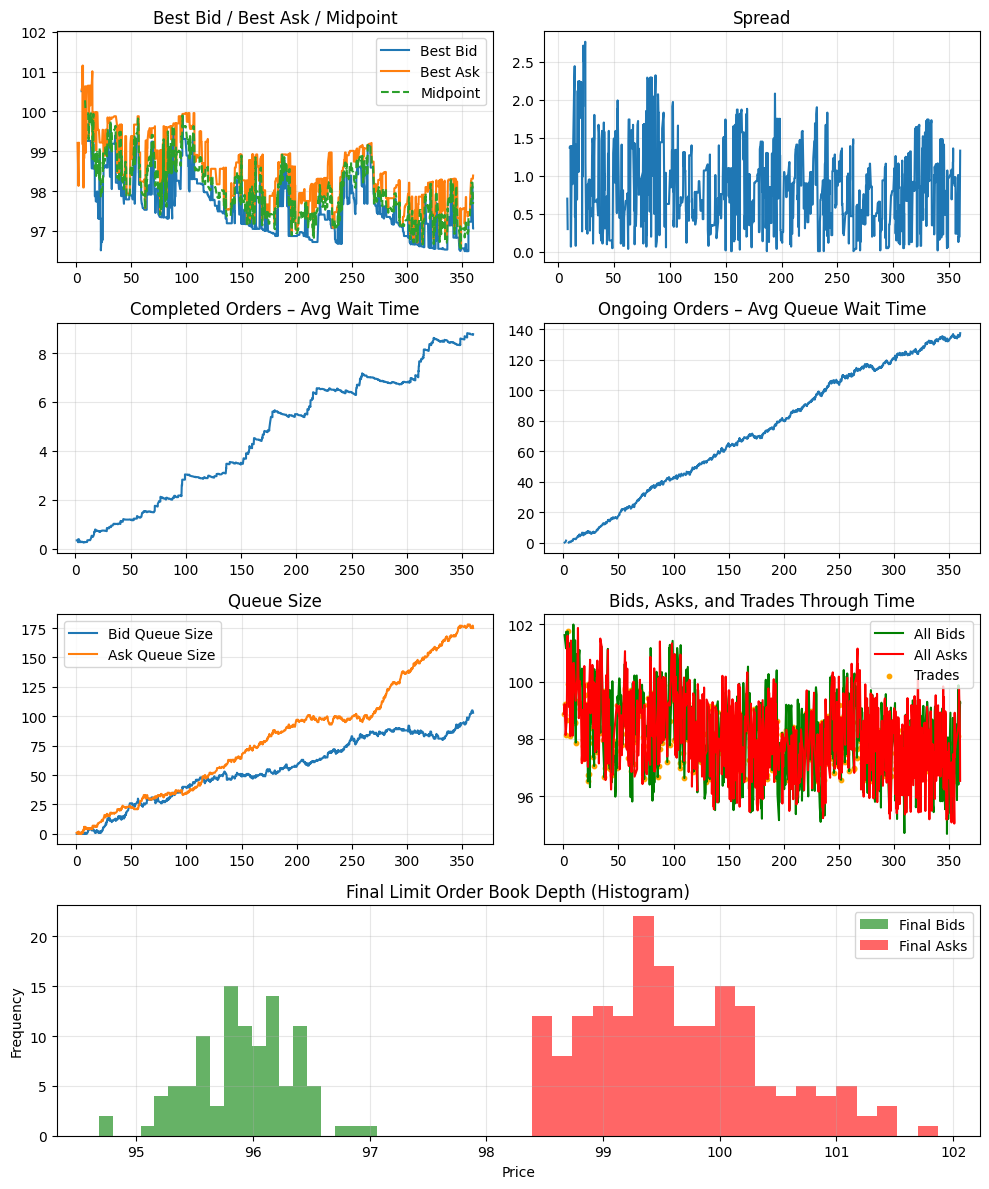

In [23]:
plot_orderbook_metrics(time,best_bids_ts, best_asks_ts, midpoint_ts, spread_ts,completed_wait_times, ongoing_wait_times,bid_queue_size, ask_queue_size,all_bids_prices, all_bids_times, all_asks_prices, all_asks_times, all_trades_prices, all_trades_times,orderbook_bids,orderbook_asks)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

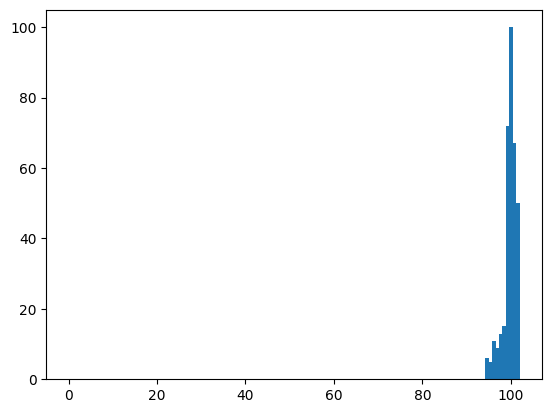

In [57]:
plt.hist(output_simulation_results(simulation_results)[3][1])
plt.hist(output_simulation_results(simulation_results)[2][1])